In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets

In [2]:
class config:
    input = 28*28
    output = 10
    hid = 256    # RC Neurons
    thr = 0.5
    decay = 0.5
    rst = 0.05
    
    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    
    num_minibatch = 10000
    num_per_label_minibatch = 20 # number of samples of each label in one mini-batch
    batch = 128
    epoch = 10
    lr = 0.001
    device = torch.device('cuda:0')
    

In [3]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
from spikingjelly.datasets.n_mnist import NMNIST

nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

# SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=20, split_by='number')
# SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=20, split_by='number')
# train_loader = torch.utils.data.DataLoader(dataset=SHD_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch, shuffle=False)

The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.


In [4]:
class ActFun(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < 0.5 # lens
        return grad_input * temp.float()

act_fun = ActFun.apply

In [9]:
def mem_update(input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + input
    spike = act_fun(mem - thr)
    return mem, spike

class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                    nn.Conv2d(1, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Conv2d(16, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Flatten(),
                                    self.fc_in,
                                    )
        self.fc_in.requires_grad_ = False
        self.conv_in.requires_grad_ = False
        
        # self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # 邻接矩阵
        self.A = nn.Linear(config.hid, config.hid, bias=False) # 邻接矩阵
        nn.init.uniform_(self.A.weight, a=0, b=1)
        self.fc_out = nn.Linear(hid, out)
        
        for name, p in self.named_parameters():
            if 'conv' in name or 'fc_in' in name:
                p.requires_grad = False
        
    def forward(self, input):
        batch = input.shape[0]
        time_step = 10
        input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to('cuda')
        hid_spk = torch.zeros(batch, time_step+1, config.hid).to('cuda')
        sum_spk = torch.zeros(batch, config.hid).to('cuda')
        
        for t in range(time_step):
            x = input > torch.rand(input.size()).to('cuda')
            x = self.fc_in(x.float())
            # x = self.conv_in(x.float())
            # x = self.fc_in(input[:,t,:])
            # x = self.conv_in(input[:, t, :, :, :])
            
            # x = x @ self.A
            x = F.sigmoid(self.A(x))
            
            hid_mem_tmp, hid_spk_tmp = mem_update(x, hid_mem[:,t,:], hid_spk[:,t,:], config.thr, config.decay, config.rst)
            hid_mem[:,t+1,:] = hid_mem_tmp
            hid_spk[:,t+1,:] = hid_spk_tmp
            sum_spk += hid_spk_tmp
        
        sum_spk /= time_step
        out = self.fc_out(sum_spk)
        A_norm = torch.norm(self.A.weight, p=1)
        return out, hid_mem, hid_spk, A_norm


In [16]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        now = time.time()
        for i, (samples, labels) in enumerate(tqdm(train_loader)):
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs, _, _, A_norm = model(samples.to(device))
            loss = criterion(outputs, labels) + 0.0001*A_norm # , torch.max(A_norm-6000, 0)
            loss.backward()
            optimizer.step()
        tr_acc = test(model, train_loader)
        ts_acc = test(model, test_loader)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        res_str = 'epoch: ' + str(epoch) \
                    + ' Loss: ' + str(loss.item())      \
                    + '. Tr Acc: ' + str(tr_acc)        \
                    + '. Ts Acc: ' + str(ts_acc)        \
                    + '. Time:' + str(time.time()-now)  \
                    + '. A norm:' + str(A_norm.item())
        print(res_str)
    return train_accs, test_accs

def test(model, dataloader):
    correct, total = 0, 0
    for images, labels in dataloader:
        outputs, _, _, _ = model(images.to(config.device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.long().cpu()).sum()
    accuracy = 100. * correct.numpy() / total
    return accuracy

In [17]:
def inference(data_set, model):
    img = torch.zeros(len(data_set), 28, 28)
    for i, (d,l) in enumerate(data_set):
        img[i] = d[0]
    
    labels = np.array([d[1] for d in data_set])
    idx_per_label = [np.where(labels==i)[0] for i in range(config.output)]
    # generate mini batch
    for i in range(config.num_minibatch):
        batch_idx, batch_labels = [], []
        for j in range(config.output):
            batch_idx.extend(np.random.choice(idx_per_label[j], config.num_per_label_minibatch).tolist())
            batch_labels.extend([j]*config.num_per_label_minibatch)
        batch_data = img[batch_idx]
        batch_labels = torch.tensor(batch_labels)
        
        # print(i, batch_data.shape, batch_labels)
        out, hid_mem, hid_spk = model(batch_data.to('cuda'))
        _, predicted = torch.max(out.data, 1)
        acc = (predicted.cpu() == batch_labels.long().cpu()).sum()/config.num_per_label_minibatch/config.output
        print(hid_mem.shape, hid_spk.shape, acc)

# inference(test_dataset, model)

In [18]:
model = RC().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cuda')
accuracy = test(model, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 0 Loss: 2.27983021736145. Tr Acc: 87.95. Ts Acc: 88.56. Time:71.51523947715759. A norm:19135.056640625


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1 Loss: 1.208312749862671. Tr Acc: 90.15166666666667. Ts Acc: 90.55. Time:68.56880497932434. A norm:9214.263671875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2 Loss: 0.7010195255279541. Tr Acc: 90.33833333333334. Ts Acc: 90.7. Time:66.31323266029358. A norm:3979.642333984375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3 Loss: 0.513303816318512. Tr Acc: 89.72. Ts Acc: 90.18. Time:67.29441094398499. A norm:2021.1402587890625


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4 Loss: 0.4888136386871338. Tr Acc: 89.665. Ts Acc: 90.34. Time:67.13854002952576. A norm:1356.6361083984375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5 Loss: 0.37373217940330505. Tr Acc: 89.835. Ts Acc: 90.58. Time:67.32965755462646. A norm:1052.474609375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6 Loss: 0.48203614354133606. Tr Acc: 89.875. Ts Acc: 90.43. Time:69.94015979766846. A norm:906.735107421875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7 Loss: 0.6299732327461243. Tr Acc: 90.33. Ts Acc: 90.64. Time:65.2178430557251. A norm:821.4371948242188


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8 Loss: 0.4365366995334625. Tr Acc: 90.46833333333333. Ts Acc: 90.91. Time:67.43343353271484. A norm:749.5946044921875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9 Loss: 0.5158981680870056. Tr Acc: 90.13166666666666. Ts Acc: 90.76. Time:68.54051470756531. A norm:709.04638671875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 10 Loss: 0.4428480565547943. Tr Acc: 90.745. Ts Acc: 91.14. Time:65.52695369720459. A norm:665.9967041015625


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 11 Loss: 0.3065894842147827. Tr Acc: 90.84333333333333. Ts Acc: 91.42. Time:65.78059148788452. A norm:643.4053955078125


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 12 Loss: 0.4190594255924225. Tr Acc: 90.635. Ts Acc: 90.74. Time:65.72282528877258. A norm:620.3748779296875


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
# 1-(model.A.weight.abs()<8.5e-3).sum()/65536
(model.A.weight==0).sum()

tensor(63461, device='cuda:0')

In [56]:
with torch.no_grad():
    baseline = 1e-2
    model.A.weight[model.A.weight<=1e-2]=0
    model.A.weight[model.A.weight>1e-2]=1.
    print(test(model, test_loader))

82.62


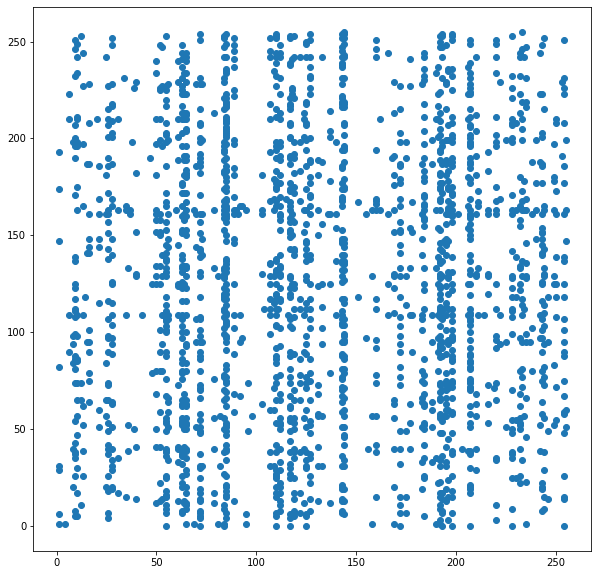

: 

In [63]:
plt.figure(figsize=(10,10))
plt.scatter(x,y)

In [61]:
A = model.A.weight.cpu().data.numpy()
x, y = np.where(A>1e-2)
for xx, yy in zip(x,y):
    print(xx, yy)
# plt.imshow(A)

1 1
1 6
1 29
1 31
1 82
1 147
1 174
1 193
4 1
6 90
6 109
6 210
6 223
8 20
8 40
8 84
8 94
8 98
8 198
9 5
9 8
9 26
9 35
9 37
9 38
9 43
9 54
9 74
9 81
9 86
9 88
9 99
9 108
9 111
9 112
9 117
9 123
9 125
9 137
9 139
9 171
9 190
9 196
9 200
9 207
9 232
9 246
9 251
10 5
10 17
10 30
10 47
10 57
10 65
10 74
10 85
10 86
10 98
10 109
10 163
10 175
10 196
10 198
10 210
10 211
10 234
10 242
10 249
12 11
12 65
12 74
12 253
13 26
13 39
13 52
13 62
13 109
13 165
13 197
13 227
13 244
14 118
15 95
15 141
15 187
16 64
16 75
16 79
16 90
16 95
16 101
16 141
16 144
16 148
16 161
16 187
16 208
16 228
20 210
21 51
21 60
21 115
21 144
21 148
21 161
21 169
21 186
25 20
25 57
25 65
25 84
25 161
25 181
25 242
26 4
26 7
26 18
26 26
26 37
26 40
26 42
26 49
26 53
26 65
26 73
26 74
26 90
26 97
26 98
26 107
26 116
26 138
26 143
26 151
26 157
26 161
26 163
26 172
26 186
26 190
26 201
26 207
26 210
26 215
26 227
28 19
28 20
28 29
28 31
28 34
28 40
28 51
28 63
28 64
28 89
28 94
28 97
28 104
28 109
28 115
28 125
28 126
28 

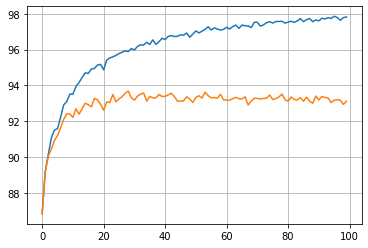

In [115]:
with open('./log/log.txt', 'r') as f:
    data = f.readlines()
test_acc = []
for d in data:
    test_acc.append(float(d.split('Ts Acc: ')[1].split('. ')[0]))
plt.plot(acc[0])
plt.plot(test_acc)
plt.grid()

In [6]:
model = RC().to('cuda')
# model.conv_in.requires_grad_ = False
for name, p in model.named_parameters():
    if 'conv' in name or 'fc_in' in name:
        p.requires_grad = False
        # print(name, p.shape)
    # if p.requires_grad is False:
    #     print(p.shape)
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 5.14K


In [17]:
model = RC()
non_zero, per_node = [], []
for i in range(256):
    model.A[i,:] = 0
    model.A[:,i] = 0
    # print(i, (model.A!=0).sum(), (model.A!=0).sum()/256)
    non_zero.append((model.A!=0).sum().item())
    per_node.append((model.A!=0).sum().item()/256)

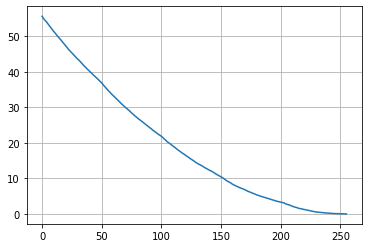

In [20]:
plt.plot(per_node)
plt.grid()

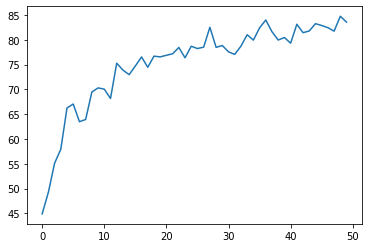

In [57]:
plt.plot(acc)

In [6]:
from thop import profile

model = RC().to('cuda')
model.conv_in.requires_grad_ = False
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
flops, params = profile(model.cuda(), inputs=(input,))
print("FLOPS: {:.2f}M".format(flops / 1e6))
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 208.72K
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPS: 31.09M
Parameters: 409.68K
